In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sklearn.preprocessing
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Régression linéaire
===

Introduction
---

La régression linéaire est très intéressante à coder soi-même : elle n'est pas trop complexe mais permet de toucher à beaucoup de concepts du machine learning.

On va ici l'illustrer avec un exemple local : Nantes a une forte politique d'ouverture des données, il est donc possible de récupérer les données de perception de TVA [sur internet](http://data.nantes.fr/donnees/detail/taxe-sur-la-valeur-ajoutee-tva-en-pays-de-la-loire/).

Passons en python quelques secondes pour charger ce dataset :

In [2]:
train_df = pd.read_csv('../data/vat/train.csv',
                       names=['year', 'month_string', 'vat'],
                       header=0)

Créez deux nouvelles features, `month` et `date`, qui contiendront respectivement les entiers correspondant aux mois pour la première et les mois combinés aux années pour la seconde. Par exemple, janvier 2017 serait `2017,00` là où février 2017 serait `2017,0833`.

In [3]:
train_df['month'] = train_df['month_string'].map(lambda x: int(x[:2]))
train_df['date'] = train_df.apply(
    lambda r: r['year'] + (r['month'] - 1) / 12,
    axis=1)

- plottez `vat` en fonction de `date`

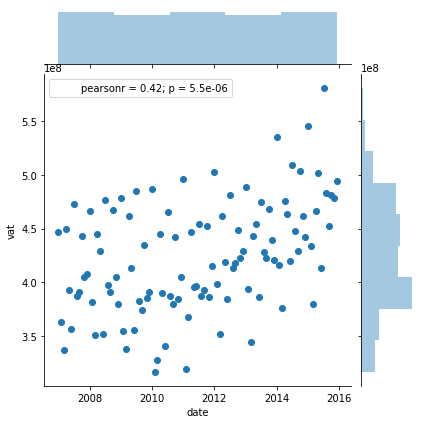

In [4]:
sns.jointplot(x='date',
              y='vat',
              data=train_df)
plt.show()

- définissez puis normalisez `X` et `y`

In [5]:
### Standardize x
X = train_df[['date']]
X_scaler = sklearn.preprocessing.StandardScaler()
X = X_scaler.fit_transform(X)

### Standardize y
Y = train_df[['vat']]
Y_scaler = sklearn.preprocessing.StandardScaler()
Y = Y_scaler.fit_transform(Y)
y = Y[:, 0]

Pour comprendre l'évolution jointe de la TVA perçue et du temps, on va se limiter à une hypothèse forte : on peut trouver une fonction affine qui modélise correctement la relation entre les entrées et les sorties. Pour rappel, une fonction affine est de la forme $h_\theta(x) = \theta_0 + \theta_1 \times x $. 

Géométriquement, on pourra représenter cette fonction par une droite.

Par exemple, ici, on aimerait trouver l'hypothèse suivante :

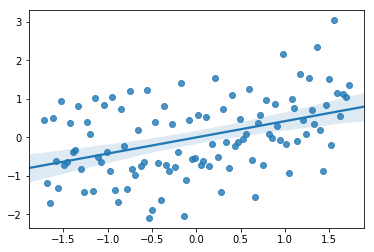

In [6]:
sns.regplot(X, y)
plt.show()

Tout ça est prometteur, mais ici nous avons utilisé [`seaborn`](https://seaborn.pydata.org/) pour calculer les paramètres de l'hypothèse qui représente au mieux les données. Nous allons maintenant voir comment le faire nous même.

### Estimation des paramètres

Pour estimer $\theta$ ($\theta_0$ et $\theta_1$), nous avons besoin de 2 éléments :

- une fonction de coût, qui nous dira pour des paramètres donnés $\theta$ si l'on se débrouille bien ou non
- une méthode d'estimation des meilleurs paramètres étant donnée cette fonction de coût

#### Prédictions

En prérequis au calcul de la fonction de coût, nous devons savoir calculer des prédictions.

Pour appliquer la transformation linéaire définie par $\theta_0$ et $\theta_1$ à $X$, on peut utiliser la multiplication de matrice : $X\theta_1 + \theta_0$

- définir la fonction `predict` pour qu'elle calcule la transformation linéaire donnée par $\theta$

In [7]:
def predict(X, theta_w, theta_b):
    return np.dot(X, theta_w) + theta_b

#### Fonction de coût

La fonction de coût la plus utilisée est la moyenne des différences entre les points réels et ceux obtenus par l'hypothèse avec les paramètres courants, le tout au carré. Pour illustrer :

![Illustration of linear least squares by Oleg Alexandrov](files/img/least-squares.png)

Dans cette exemple, si notre hypothèse est la droite bleue, alors le coût de cette hypothèse est la somme des carrés des segments verts.

En notant $L$ la fonction de coût, $n$ le nombre d'exemples d'apprentissage, on peut écrire :

$$
  L(\theta) = \sum\frac{(X\theta_1 + \theta_0 - y)^2}{2n}
$$

- définir la fonction `residuals` en vous aidant de la fonction `predict`

In [8]:
def residuals(X, y, theta_w, theta_b):
    return y - predict(X, theta_w, theta_b)

def cost(X, y, theta_w, theta_b):
    return np.mean(residuals(X, y, theta_w, theta_b) ** 2) / 2

- définir la fonction `cost` en vous aidant de la fonction `residuals`

#### Optimisation des paramètres

Optimiser les paramètres revient à minimiser la fonction de coût :

$$\min_{\theta} \sum\frac{(X\theta_1 + \theta_0 - y)^2}{2n}$$

Pour ce faire, il existe une formule directe que nous n'utiliserons pas dans ces travaux pratiques pour deux raisons : elle n'est pas applicable aux très grands datasets et la méthode que l'on va utiliser pourra être réutilisée pour la régression logistique et d'autres techniques (réseaux de neurones généraux, gradient boosted trees, etc).

Nous allons utiliser la descente de gradient. Cette méthode est itérative et fait des pas successifs en suivant la dérivée (pour maximiser) ou son opposé (pour minimiser) la fonction de perte. Dans le cas de la régression linéaire, elle converge vers l'optimum global (la meilleure solution).

![An illustration of the gradient descent method by Oleg Alexandrov](files/img/gradient-descent.png)

En pseudo-code, l'algorithme est (avec les bons gradients calculés):

$$
\begin{aligned}
& \text{tant que ça n'a pas convergé :} \\
& \quad \theta_0 \leftarrow \theta_0 - \alpha \sum\frac{X\theta_1 + \theta_0 - y}{n} \\
& \quad \theta_1 \leftarrow \theta_1 - \alpha \frac{X^T(X\theta_1 + \theta_0 - y)}{n} \\
\end{aligned}
$$

où $\alpha$ est le pas d'apprentissage.


- implémenter la fonction `gradient` en vous aidant de la fonction `residuals`

In [9]:
def gradient(X, y, theta_w, theta_b):
    neg_residuals = -residuals(X, y, theta_w, theta_b)
    g_w = X.T.dot(neg_residuals) / y.size
    g_b = neg_residuals.mean()
    return g_w, g_b

Il ne reste qu'à conclure :

- implémenter la descente de gradient dans la fonction `gradient_descent`

In [10]:
def gradient_approx(X, y, theta_w, theta_b, epsilon=1e-4):
    below = theta_b - epsilon
    above = theta_b + epsilon
    grad_b = ((cost(X, y, theta_w, above)
               - cost(X, y, theta_w, below))
              / (2 * epsilon))
    grad_w = []
    for i in range(theta_w.size):
        below = theta_w.copy()
        below[i] -= epsilon
        above = theta_w.copy()
        above[i] += epsilon
        grad_w += [(cost(X, y, above, theta_b)
                    - cost(X, y, below, theta_b))
                   / (2 * epsilon)]
    return grad_w, grad_b

def gradient_descent(X,
                     y,
                     alpha,
                     max_iter=1000,
                     gradient_check=True):
    theta_w = np.zeros(X.shape[1])
    theta_b = 0.
    # we'll keep an history of the costs during the optimization and will
    # return it at the end
    costs = [cost(X, y, theta_w, theta_b)]
    for i in range(max_iter):
        grad_w, grad_b = gradient(X, y, theta_w, theta_b)
        if gradient_check:
            grad_a_w, grad_a_b = gradient_approx(X, y, theta_w, theta_b)
            if not -1e-7 < grad_b - grad_a_b < 1e-7:
                print('Gradient checking failed for theta0')
            for g, ga in zip(grad_w, grad_a_w):
                if not -1e-7 < g - ga < 1e-7:
                    print('Gradient checking failed for theta1')
        theta_w -= alpha * grad_w
        theta_b -= alpha * grad_b
        costs += [cost(X, y, theta_w, theta_b)]
    return theta_w, theta_b, costs

theta_w, theta_b, costs = gradient_descent(
    X,
    y,
    0.006,
    1000,
    gradient_check=True)


Vérification de notre hypothèse
---

Nous pouvons maintenant vérifier le modèle appris avec quelques plots :

- plot des valeurs prédites contre les valeurs réelles
- plot des résiduels
- plot des coûts d'entrainement

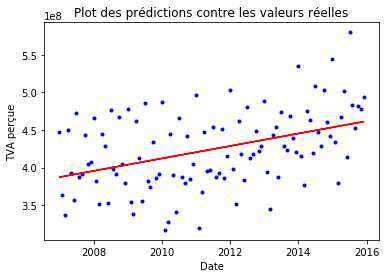

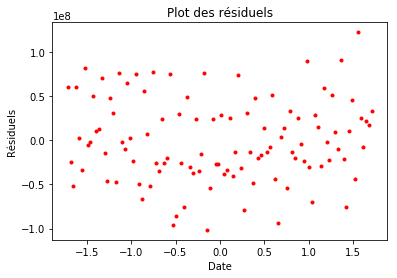

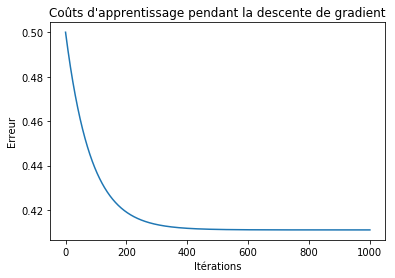

In [11]:
inv_X = X_scaler.inverse_transform(X)
inv_Y = Y_scaler.inverse_transform(Y)
inv_Yh = Y_scaler.inverse_transform(predict(X, theta_w, theta_b))[:, None]

plt.plot(inv_X, inv_Y, 'b.')
plt.plot(inv_X, inv_Yh, 'r')
plt.title('Plot des prédictions contre les valeurs réelles')
plt.xlabel('Date')
plt.ylabel('TVA perçue')
plt.show()

plt.plot(X, inv_Y - inv_Yh, 'r.')
plt.title('Plot des résiduels')
plt.xlabel('Date')
plt.ylabel('Résiduels')
plt.show()

plt.plot(range(len(costs)), costs)
plt.title("Coûts d'apprentissage pendant la descente de gradient")
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()